# **Preface**

Now we work on Nvidia stock price forecast. The stock price historical
data is available on [**kaggle**](https://www.kaggle.com/datasets/harshsingh2209/nvidia-stock-pricing-20172022).
We also introduce our own forecast method which originates from various
forecasting techniques developed by timeseries analysts out there
with a few modification from us. We will also present the mathematical
construction of the method in the language of measure
theoretic-probability theory.

In [1]:
# LIBRARIES
# Data Manipulation, Analysis and Visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set_style("dark")

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, \
                                          DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

# **Data Overview**

Let us first observe the data. We present the data as follows.

In [2]:
# Data Setup
nvidia_df = pd.read_csv("NVDA.csv",
                        parse_dates= ["Date"],
                        infer_datetime_format= True)
nvidia_df["Date"] = nvidia_df.Date.dt.to_period("D")
nvidia_df = nvidia_df.set_index("Date").sort_index()

# Presenting the data
print("The first 5 rows of the Nvidia share price history:")
display(nvidia_df.head())

print("\nThe last 5 rows of the Nvidia share price history:")
display(nvidia_df.tail())

The first 5 rows of the Nvidia share price history:


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-06-12  36.470001  37.924999  35.527500  37.492500  37.076328  169753200
2017-06-13  38.599998  38.692501  36.412498  37.849998  37.429855  167250400
2017-06-14  37.880001  38.514999  37.125000  37.930000  37.508972  118464000
2017-06-15  36.740002  38.400002  36.625000  38.092499  37.669662   96382400
2017-06-16  38.189999  38.674999  37.560001  37.904999  37.484249   92496000


The last 5 rows of the Nvidia share price history:


Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-06  191.389999  193.369995  185.639999  187.860001  187.820297   
2022-06-07  184.720001  190.000000  181.880005  189.259995  189.219986   
2022-06-08  187.990005  191.800003  185.350006  186.479996  186.479996   
2022-06-09  184.809998  189.330002  180.410004  180.479996  180.479996   
2022-06-10  176.000000  176.970001  168.690002  169.740005  169.740005   

              Volume  
Date                  
2022-06-06  42240600  
2022-06-07  38891400  
2022-06-08  36325200  
2022-06-09  39557400  
2022-06-10  46524800

To have a better understanding on the data, let us visualise the data.
First, we present the lineplots of the data as follows.

In [3]:
# Simple visualisation function:
def simple_vis(ts, titles, xlabs, ylabs, figsize= (18, 6)):
    ts_cols = ts.columns
    n_row = len(ts_cols)
    fig = plt.figure(figsize= (figsize[0], n_row *figsize[1]))
    gs = fig.add_gridspec(n_row, 1)
    ax = [[fig.add_subplot(gs[i, j]) for j in range(1)]
          for i in range(n_row)]
    axs = [None] *n_row
    for i, ax_, col, tit, xl, yl in zip(range(n_row),
                                        axs,
                                        ts_cols,
                                        titles,
                                        xlabs,
                                        ylabs):
        ax_ = ts[col].plot(ax= ax[i][0])
        ax_.set_title(tit,
                      pad= 12,
                      fontsize= 15,
                      fontweight= "bold")
        ax_.set(xlabel= xl, ylabel= yl)
        plt.subplots_adjust(hspace= 0.3);

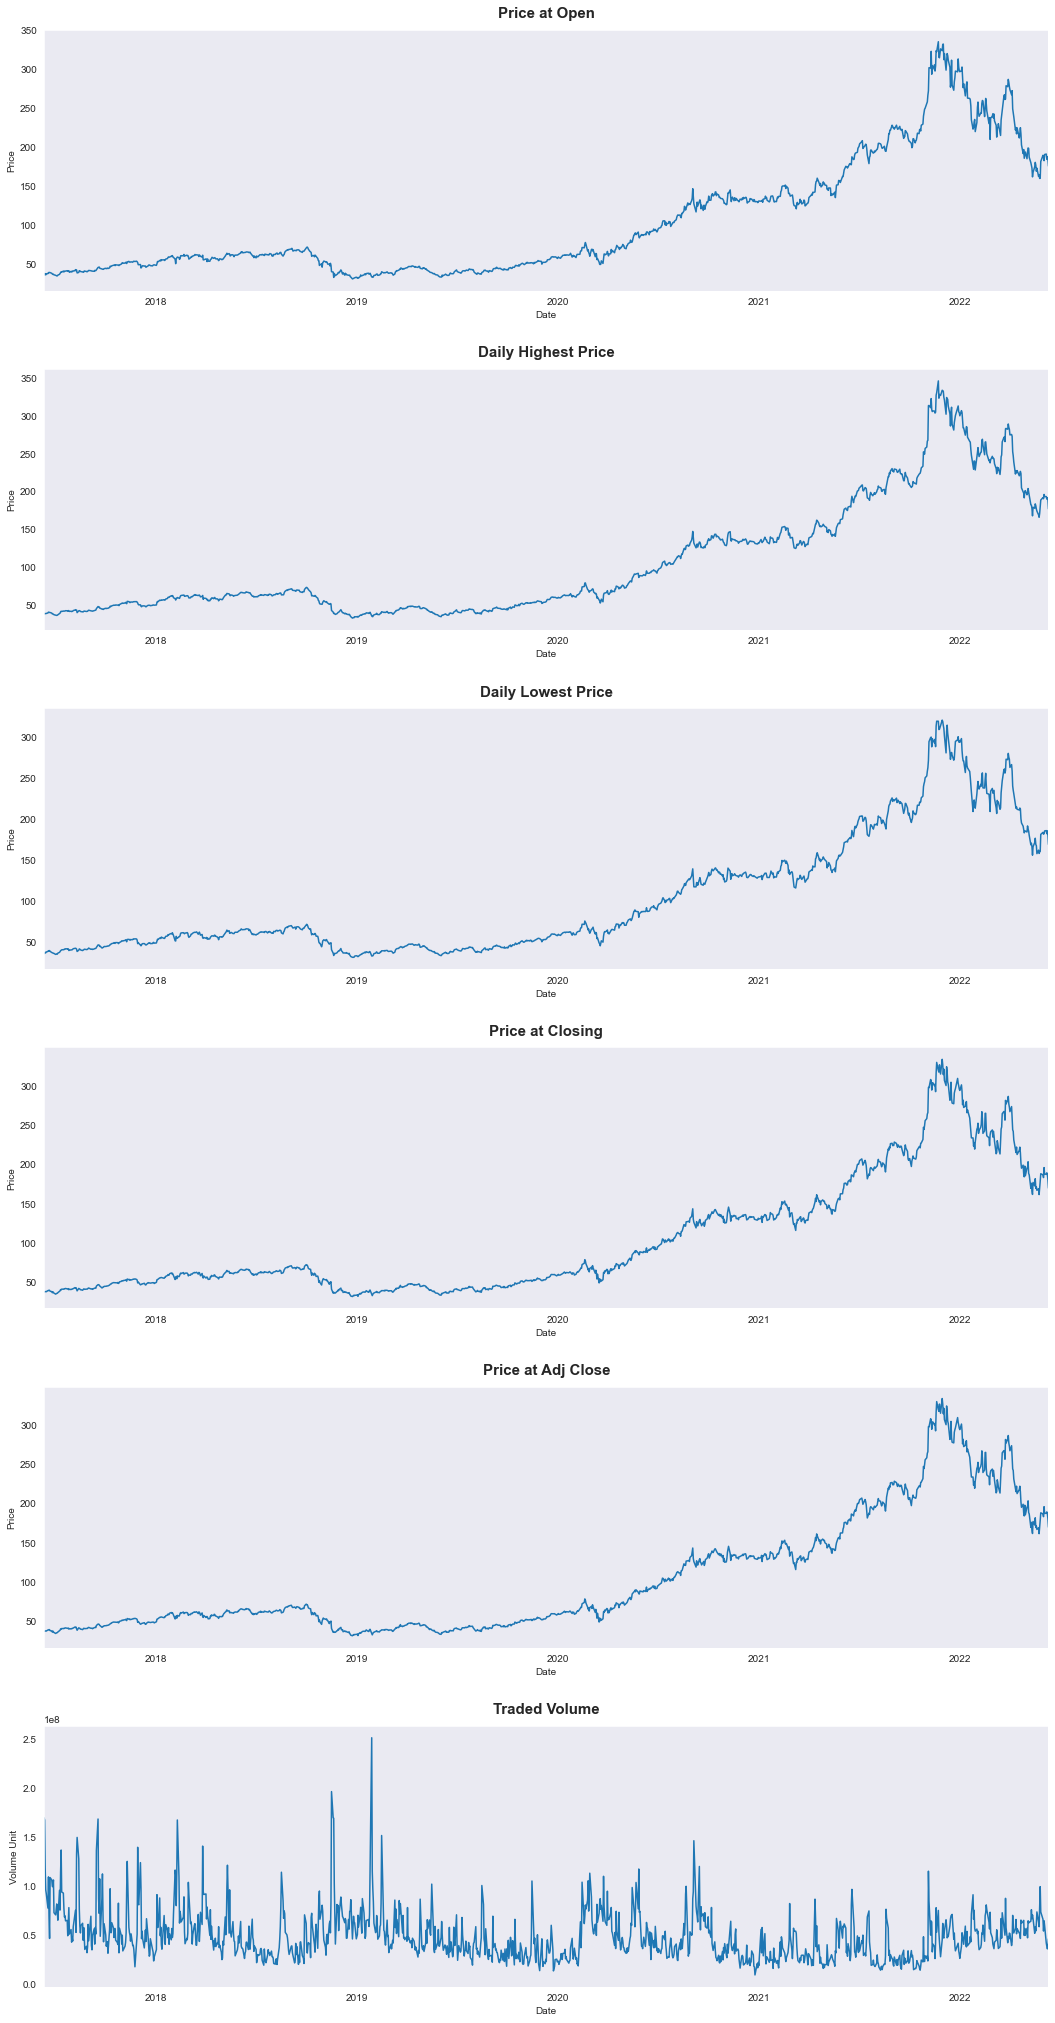

In [4]:
# The data is visualised as follows:
titles = ["Price at Open",
          "Daily Highest Price",
          "Daily Lowest Price",
          "Price at Closing",
          "Price at Adj Close",
          "Traded Volume"]
xlabs = ["Date"] *len(nvidia_df.columns)
ylabs = ["Price", "Price", "Price", "Price", "Price", "Volume Unit"]
simple_vis(nvidia_df, titles, xlabs, ylabs)

Now we can also present the data --which only includes columns
`Open`, `High`, `Low`, `Close`-- into a candlestick chart.
The chart is given as follows.

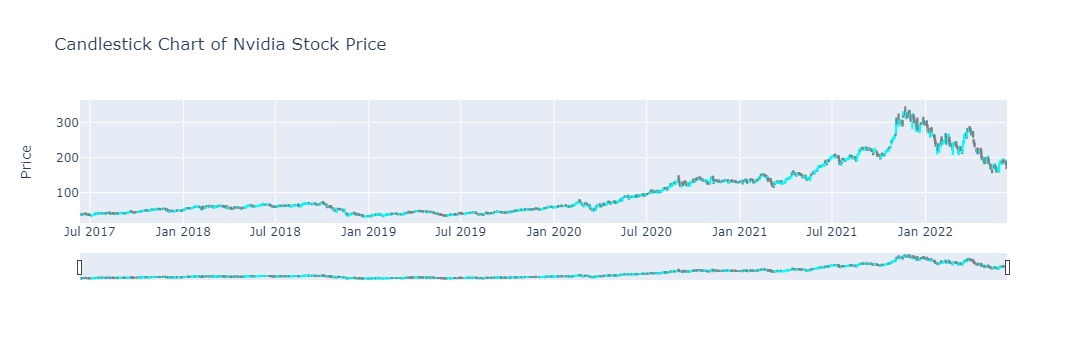

In [5]:
nvd_idx = nvidia_df.copy().index.strftime("%Y-%m-%d")
figori_cs = go.Figure(
    data= [go.Candlestick(x= nvd_idx,
                          open= nvidia_df["Open"],
                          high= nvidia_df["High"],
                          low= nvidia_df["Low"],
                          close= nvidia_df["Close"],
                          increasing_line_color= "cyan",
                          decreasing_line_color= "gray"
                         )
          ]
)
figori_cs.update_layout(
    title= "Candlestick Chart of Nvidia Stock Price",
    yaxis_title= "Price")
figori_cs.show()

# **Forecasting Technique**

Now let us present our forecasting technique for this project.

## **A. Naive Explanation**
The forecasting technique we use follows the following steps:
1. First we determine the major trend of each feature. To observe the
best possible trend, we generate a moving average trend for each
feature. From the moving average trend, we create an approximation by
making use of a polynomial function.
2. Once we have the major trends set, we continue to determine
the noises. The noises are obtained by detrending the original data
from the major trend. That is, we subtract the original data from the
major trend. As the graphs above have told us, we will approximate
the noises by making use of the lagged features method.
3. Once we have the model that approximates the major trends and the
noises, we will use the model for forecasting.

Next, we explain the mathematical concept underlying the method described
above on the following section.

## **B. Probability Theoretic Interpretation**
From Nvidia stock price history, we can see that we have a data frame
ordered by dates with six features about the daily prices and
daily traded volumes of the stock. Thus we can think of this historical
data as a mapping $\mathbf{Y}: T \to \mathbb{R}^6$, where $T$ is the
set of a discrete time interval. For convenience, we can represent the
row of the data frame at time $t \in T$ simply by
$\mathbf{Y}_t \in \mathbb{R}^6$.


### **B.1 Interpreting the Data Into Random Variables**
We may now break down this model in terms of measure
theoretic-probability theory. Now suppose a probability space
$(T,\, \mathcal{F},\, P)$ [1][2] models the stock price history.
Now, for every $k \in \{1, \dotsc, 6\}$, let $Y_k: T \to \mathbb{R}$
be a random variable. $Y_k$ represents the $k^{th}$ feature in the data
frame, for every $k \in \{1, \dotsc, 6\}$. Then we designate

$$
\forall t \in T \,,\;
\mathbf{Y}_t := \big( Y_1(t), \dotsc, Y_6(t) \big) \,.
$$

If we condsider

$$
\forall k \in \{1, \dotsc, 6\} \forall t \in \Omega
\,,\; Y_{k, t} := Y_k(t) \,,
$$

then we may express

$$
\forall t \in T \,,\;
\mathbf{Y}_t = \big( Y_{1, t}, \dotsc, Y_{6, t} \big) \,.
$$

Then $\mathbf{Y}$ is a random vector on the probability space
$(T,\, \mathcal{F},\, P)$. Note that $\mathbf{Y}$ is a measurable
function [2].

### **B.2 Important Probability Theoretic Concepts**
**Definition 1** (Expected Value). Let $(\Omega,\, \mathcal{F},\, P)$
be a probability space [1]. Let $\mathcal{L}^1(P)$ be the space of
all random variables on $(\Omega,\, \mathcal{F},\, P)$ [2]. *Expected value*
[4] is a map $\mathrm{E}: \mathcal{L}^1(P) \to \mathbb{R}$ defined by the
Lebesgue integral [2]

$$
\forall X \in \mathcal{L}^1(P) \,,\;
\mathrm{E}[X] := \int_\Omega X \,dP \,.
$$

**Definition 2** (Covariance). Let $(\Omega,\, \mathcal{F},\, P)$ be
a probability space [1]. Let $\mathcal{L}^1(P)$ be the space of all
random variables on $(\Omega,\, \mathcal{F},\, P)$ [2]. *Covariance* [3]
is a map $\mathrm{cov}: \mathcal{L}^1(P) \times \mathcal{L}^1(P)
\to \mathbb{R}$ defined by

$$
\forall X, Y \in \mathcal{L}^1(P) \,,\;
\mathrm{cov}(X, Y)
:= \mathrm{E}[ (X - \mathrm{E}[X]) (Y - \mathrm{E}[Y]) ] \,.
$$

**Theorem 1** (Covariance Expanded). *Let $(\Omega,\, \mathcal{F},\, P)$
be a probability space. Let $\mathcal{L}^1(P)$ be the space of all random
variables on $(\Omega,\, \mathcal{F},\, P)$ [2].
The covariance on $(\Omega,\, \mathcal{F},\, P)$ can also be defined by

$$
\forall X, Y \in \mathcal{L}(P) \,,\;
\mathrm{cov}(X,\, Y) = \mathrm{E}[XY] - \mathrm{E}[X]\mathrm{E}[Y] \,.
$$

*Proof*. Let $X, Y \in \mathcal{L}^(P)$. 
Definition 1 asserts the definition of expected value in the
form of Lebesgue integral. It shows that the expected value of $X$ and
$Y$ are of real values. Then let $x, y \in \mathbb{R}$ such that
$x = \mathrm{E}[X]$ and $y = \mathrm{E}[Y]$.
Definition 2 asserts the definition of covariance which involves
expected values. Then by the $\sigma$-additive property of
Lebesgue integral [2], we obtain

$$
\begin{split}
\mathrm{cov}(X,\, Y)
&= \mathrm{E}[ (X - \mathrm{E}[X]) (Y - \mathrm{E}[Y]) ] \\
&= \mathrm{E}[ (X - x) (Y - y) ] \\
&= \mathrm{E}[ XY - Xy - xY + xy ] \\
&= \int_\Omega XY - Xy - xY + xy \,dP \\
&= \int_\Omega XY \,dP - \int_\Omega Xy \,dP - \int_\Omega xY \,dP
    + \int_\Omega xy \,dP \\
&= \int_\Omega XY \,dP - y\int_\Omega X \,dP - x\int_\Omega Y \,dP
    + xy\int_\Omega \,dP \\
&= \mathrm{E}[XY] - \mathrm{E}[Y]\mathrm{E}[X]
    - \mathrm{E}[X]\mathrm{E}[Y] + \mathrm{E}[X]\mathrm{E}[Y] \\
&= \mathrm{E}[XY] - \mathrm{E}[X]\mathrm{E}[Y] \,,
\end{split}
$$

which proves the theroem.

**Definition 3** (Variance). Let $(\Omega,\, \mathcal{F},\, P)$ be a
probability space [1]. Let $\mathcal{L}^1(P)$ be the space of all random
variables on $(\Omega,\, \mathcal{F},\, P)$ [2]. *Variance* is a map
$\mathrm{var}: \mathcal{L}^1(P) \to \mathbb{R}$ defined by

$$
\forall X \in \mathcal{L}^1(P) \,,\;
\mathrm{var}(X) := \mathrm{cov}(X, X) \,.
$$

**Proposition 1** (Variance Expanded). Let $(\Omega,\, \mathcal{F},\,
P)$ be a probability space [1]. Let $\mathcal{L}^1(P)$ be the space of all
random variables on $(\Omega,\, \mathcal{F},\, P)$ [2]. 

1. From definition 2 and definition 3, we will obtain

$$
\forall X \in \mathcal{L}^1(P) \,,\;
\mathrm{var}(X) = \mathrm{E}[ (X - \mathrm{E}[X])^2 ] \,.
$$

2. By theorem 1, the definition of variance as given by definition 3
can be expanded into

$$
\forall X \in \mathcal{L}^1(P) \,,\;
\mathrm{var}(X) = \mathrm{E}[X^2] - \mathrm{E}[X]^2
\,.
$$

**Definition 4** (Standard Deviation). Let $(\Omega,\, \mathcal{F},\,
P)$ be a probability space. Let $\mathcal{L}^1(P)$ be the space of all
random variables on $(\Omega,\, \mathcal{F},\, P)$. *Standard deviation*
is a map $s: \mathcal{L}^1(P) \to \mathbb{R}$ defined by

$$
\forall X \in \mathcal{L}^1(P) \,,\;
s(X) := \sqrt{ \mathrm{var}(X) } \,.
$$

**Proposition 2** (Standard Deviation Expanded).
Let $(\Omega,\, \mathcal{F},\, P)$ be a probability space [1]. Let
$\mathcal{L}^1(P)$ be the space of all random variables on
$(\Omega,\, \mathcal{F},\, P) [2]$.

1. From (i) of proposition 1 and from definition 4, we obtain

$$
\forall X \in \mathcal{L}^1(P) \,,\;
s(X) = \sqrt{ \mathrm{E}[(X - \mathrm{E}[X])^2] } \,.
$$

2. From (ii) of proposition 1 and from definition 4, we obtain

$$
\forall X \in \mathcal{L}^1(P) \,,\;
s(X) = \sqrt{ \mathrm{E}[X^2] - \mathrm{E}[X]^2 } \,.
$$

**Definition 5** (Correlation). Let $(\Omega,\, \mathcal{F},\, P)$ be
a probability space [1]. Let $\mathcal{L}^1(P)$ be the space of all random
variables on $(\Omega,\, \mathcal{F},\, P)$ [2]. *Correlation* is a map
$\mathrm{corr}: \mathcal{L}^1(P) \times \mathcal{L}^1(P) \to \mathbb{R}$
defined by

$$
\forall X, Y \in \mathcal{L}^1(P) \,,\;
\mathrm{corr}(X, Y) := \frac{\mathrm{cov}(X, Y)}{s(X) s(Y)} \,.
$$

**Proposition 3** (Correlation Expanded).
Let $(\Omega,\, \mathcal{F},\, P)$ be a probability space [1].
Let $\mathcal{L}^1(P)$ be the space of all random variables on
$(\Omega,\, \mathcal{F},\, P)$ [2]. By definition 2 and (ii) of proposition 2
we obtain

$$
\forall X, Y \in \mathcal{L}^(P) \,,\;
\mathrm{corr}(X, Y) = \frac{ \mathrm{E}[X Y] - \mathrm{E}[X]\mathrm{E}[Y]
    }{ \sqrt{ (\mathrm{E}[X^2]\mathrm{E}[Y^2]
               - \mathrm{E}[X^2]\mathrm{E}[Y]^2
               - \mathrm{E}[X]^2\mathrm{E}[Y^2]
               + \mathrm{E}[X]^2\mathrm{E}[Y]^2 }
    } \,.
$$


## **C. Forecasting Method**

Let $k \in \{1, \dotsc, 6\}$.
Let us observe a random variable $Y_k: \Omega \to \mathbb{R}$ on the
probability space $(\Omega,\, \mathcal{F},\, P)$ representing the data.
After observing the graphs of the data earlier, we can consider that each
feature consists of several components, those are the trends (major,
secondary, and so on) and the noise. Suppose that there are
$m \in \mathbb{N}$ underlying trends for each feature. Now let
$X_{k, 1}, \dotsc, X_{k, m}: T \to \mathbb{R}$ represent the trends,
and let $\nu_k: T \to \mathbb{R}$ represent the noise.
Then we can express $Y_k$ by

$$
\forall t \in T \,,\;
Y_{k, t} := \left( \sum_{i = 1}^m X_{k, i, t} \right) + \nu_{k, t} \,.
$$

Now, our task is approximating $X_{k, 1}, \dotsc, X_{k, m}$ and $\nu_k$
by making use of machine learning model. The approximated functions are
$\hat{X}_{k, 1}, \dotsc, \hat{X}_{k, m}: T \to \mathbb{R}$ and
$\hat{\nu}_k: T \to \mathbb{R}$. By introducing some error function
$\varepsilon_{k}: T \to \mathbb{R}$, we have

$$
\forall t \in T \,,\;
Y_{k, t} = \left( \sum_{i = 1}^m \hat{X}_{k, i, t} \right)
            + \hat{\nu}_{k, t} + \varepsilon_{k, t} \,.
$$

And the approximated $Y_k$, is given by

$$
\forall t \in T \,,\;
\hat{Y}_{k, t} = \left( \sum_{i = 1}^m \hat{X}_{k, i, t} \right)
                    + \hat{\nu}_{k, t} \,.
$$

There are several methods in determining $\hat{X}_{k, 1}, \dotsc,
\hat{X}_{k, m}, \hat{\nu}_k$. The methods that we will use are
timestamp or lag features, or the combination of the two.

### **C.1 Timestamp**
We will most likely be using the timestamp method for the trends.
Let $j \in \{1, \dotsc, m\}$.
Suppose $f_{j, 1}, \dotsc, f_{j, n}: T \to \mathbb{R}$ are
functions (mostly linear) describing $X_{k, j}$,
with $n \in \mathbb{N}$. Now let us define a function
$\mathbf{f}_j: T \to \mathbb{R}^n$ by

$$
\forall t \in T \,,\;
\mathbf{f}_j(t) := \big( f_{j, 1}(t), \dotsc, f_{j, n}(t) \big) \,.
$$

Then there exists some function $F_j: \mathbb{R}^n \to \mathbb{R}$
such that

$$
\hat{X}_{k, j} = F_j \circ \mathbf{f}_j: T \to \mathbb{R} \,.
$$

Our task will be determining the $f_{j, 1}, \dotsc, f_{j, n}$
appropriately. Then $F_j$ will be determined by the chosen machine
learning model.

### **C.2 Lagged Features**
In our forecast, we will most likely be using lagged features to
determine $\hat{\nu}_k$. Suppose $L_k$ is the set of all appropriate
number of lags for $\nu_k$. Then for every $p \in L_k$, a $p$-lagged
feature is a map $\lambda_p: T \to \mathbb{R}$ defined by

$$
\forall t \in T \,,\;
\lambda_p(t) := \nu_{k,\, t - p} \,.
$$

Now let us define a function $\Lambda_k: T \to \mathbb{R}^{|L_k|}$ by

$$
\forall t \in T \,,\;
\Lambda_k(t) := \big( \lambda_p(t) \big)_{p \in L_k} \,.
$$

Then there exists some function $\Phi_k: \mathbb{R}^{|L_k|} \to \mathbb{R}$
such that

$$
\forall t \in T \,,\;
\hat{\nu}_k = \Phi_k \circ \Lambda_k \,.
$$

The function $\Phi_k$ will be determined by the machine learning model.
Then we determine $L_k$ by observing the partial autocorrelation
function (PACF) of $\nu_{k, t - 1}, \nu_{k, t - 2}, \dotsc, \nu_{k, t - q}$
where $q$ is the desired maximum number of lags.

### **C.3 Forecasting**
Suppose $\tilde{T}$ is the future time set that we are about to forecast.
We may call it the ***forecast horizon***. The machine learning model
for $F_j$ is assumed to be sufficient to forecast the major trends on
$\tilde{T}$ from the timestamp features. However, forecasting the noise
is not as straight forward as the trends.

We need to construct lagged features for $\tilde{T}$. We can do this by
setting

$$
\forall t \in T \,,\;
\lambda_p(t) = \nu_{k,\, t - (p + |\tilde{T}|)}
$$

for every $p \in L_k$. Note that this method will influence the
determination of $\tilde{T}$, since we want a good correlation between
$\nu_k: T \to \mathbb{R}$ and $\tilde{\nu}_k: T \to \mathbb{R}$ where

$$
\forall t \in T \,,\;
\tilde{\nu}_{k, t} := \nu_{k,\, t - |\tilde{T}|} \,,
$$

for a good forecast result. Follows from definition 5, the correlation
is given by

$$
\mathrm{corr}(\nu_k, \tilde{\nu}_k)
= \frac{\mathrm{cov}(\nu_k, \tilde{\nu}_k)}{s(\nu_k) s(\tilde{\nu}_k)}
$$

where $\mathrm{cov}$ is the covariance as described on definition 2
and $s$ is the standard deviation as described on definition 4.

Another way of measuring the accuracy of the model is by conducting
a validation. It can be done by measuring the mean absolute error
(or another appropriate error metric) between the original timeseries
with the predicted timeseries by making use of the model already built.


**Bibliography**

[1] Kolmogorov, Andrey N. (1950)[1933].
"Foundations of the Probability Theory". New York: Chelsea Publishing Company.

[2] Salamon, Dietmar A. (2016). "Measure and Integration".
Zurich: European Mathematical Society.

[3] Park, Kun II. (2018). "Fundamentals of Probability and Stochastic
Processes with Applications to Communications". New York: Springer.

[4] Billingsley, Patrick. (1995). "Probability and Measure".
Wiley Series in Probability and Mathematical Statistics
(Third edition of 1979 original ed.). New York: John Wiley & Sons, Inc.

# **Building the Machine Learning Model**

Based on the theory presented above, we now build an algorithm for the
forecast. The algorithm is created as a class which contains methods
for the forecast. We present the class as follows.

In [6]:
class Forecast:
    def __init__(self, ts):
        # 'ts' stands for timeseries
        self.ts = ts
        
        from statistics import mean
        from math import ceil, sqrt
        self.__mean = mean
        self.__ceil = ceil
        self.__sqrt = sqrt
    
    def read_me(self):
        return (
        """
        ----------------------------------------------------------------
        ___About the class
        
            This class contains the machinary to deal with the
        forecasting tasks. The class takes a pandas data frame as an
        input which is then instantiated as a class attribute 'ts'.
        The data frame is generally a time series data, which can have
        multiple columns, in the sense that, there are finite
        multi-dimensional observations at a given time.
            The outline of the forecasting tasks offered by this class
        is described as follows:
            1. First, we determine the major trend of each observation
               (column) in the time series by making use of the moving
               average trend.
            2. Then we create a model that approximates the moving
               average trends. These approximated trends are then
               considered as the major trends.
            3. We determine the noises of the data by detrending the
               data. That is, the noises are defined as the subtraction
               of the original data from the major trends.
            4. Then we create a model to approximate the noises.
            5. Finally, we can perform a forecasting by making use of
               the model we created to approximate the major trends and
               the model we created to approximate the noises.
               
                                                    Author,
                                                    Rizal Purnawan
        ----------------------------------------------------------------
        """
        )
        
    # Here we create methods for some concepts in probability theory
    # that we have explained earlier. Actually these methods are
    # available in pandas methods. However we may use this version.
    def __expected_value(self, X):
        # Argument 'X' has to be a list that represents the
        # numerical values of the observation (discrete random variable).
        # We will use definition 1 to build the algorithm --however,
        # in case that our algo is only compatible for discrete
        # random variables with fair probability distributions.
        uniq_vals = list(set(X))
        count_vals = [X.count(x) for x in uniq_vals]
        prob_mass = [n / len(X) for n in count_vals]
        return sum([p * x for p, x in zip(uniq_vals, prob_mass)])
    
    def __covariance(self, X, Y):
        # Arguments "X" and "Y" have to be lists that represents the
        # numerical values of the observations (discrete random
        # variables).
        ev_X, ev_Y = self.__expected_value(X), self.__expected_value(Y)
        XY = [x * y for x, y in zip(X, Y)]
        ev_XY = self.__expected_value(XY)
        return ev_XY - (ev_X *ev_Y)
    
    def __variance(self, X):
        # Argument "X" has to be a list that represent the numerical
        # values of the observation (discrete random variable).
        return self.__covariance(X, X)
    
    def __standard_dev(self, X):
        # Argument "X" has to be a list that represent the numerical
        # values of the observation (discrete random variable).
        sqrt = self.__sqrt
        return sqrt(self.__variance(X))
    
    def __correlation(self, X, Y):
        # Arguments "X" and "Y" have to be lists that represents the
        # numerical values of the observations (discrete random
        # variables).
        sqrt = self.__sqrt
        return (
            self.__covariance(X, Y)
            / sqrt( self.__variance(X) * self.__variance(Y) )
        )
        
    def moving_avg_trends(self, window):
        """
        ___Additional Info
        
            The argument 'window' is the window for rolling method in
        pandas.
        """
        ceil = self.__ceil
        ts = self.ts.copy()
        cols = ts.columns
        ma_trends = dict()
        for col in cols:
            y = ts[col].squeeze()
            y_ma = y.rolling(window= window,
                             min_periods= ceil(window/2),
                             center= True).mean()
            ma_trends[col] = y_ma
        ma_trends = pd.DataFrame(ma_trends, index= ts.index)
        self.ma_trends = ma_trends
        print(">>> Moving average trends are set")
        
    def __det_polynom_ord(self, max_ord= 10):
        """
        ___Additional Info
        
            This method is created to determine the order of the
        polynomial used to approximate the major trends based on the
        moving average trends that have been computed. In doing so,
        we will iterate all the possible polynomial orders such that it
        forms trends that have the smallest mean absolute error to the
        moving average trends. However we set the maximum possible
        order of the polynomial (argument 'max_ord') to 10 in default,
        since we do not want to obtain a misleading forecasting with
        considerably higher polynomial orders.
        """
        ts = self.ts.copy()
        ma_trends = self.ma_trends.copy()
        cols = ts.columns
        dp_ords = list()
        mean = self.__mean
        for col in cols:
            mae_list = list()
            for ord in range(1, max_ord + 1):
                dp = DeterministicProcess(index= ts.index,
                                          constant= True,
                                          order= ord)
                X_maj = dp.in_sample()
                y = ts[col].squeeze()
                model = LinearRegression(fit_intercept= False)
                model.fit(X_maj, y)
                y_maj = model.predict(X_maj)
                mae_list.append(
                    [ord, mean([abs(ma_trends[col][k] - y_maj[k])
                                for k in range(len(y_maj))])
                    ]
                )
            ord_ = [a for a, b in mae_list
                      if b == min([m[1] for m in mae_list])][0]
            dp_ords.append(ord_)
        self.dp_ords = dp_ords
        
    def set_major_trends(self, dp_params= None):
        """
        ___Additional Info
        
            Argument 'dp_params' has to be a list of positive
        integres. It contains the polynomial order for each column
        in the time series. By default we set it 'None', and it takes
        the result from method '__det_polynom_ord'. Otherwise, one may
        determine the value as desired.
        """
        if dp_params is None:
            self.__det_polynom_ord()
            dp_params = self.dp_ords
        ts = self.ts.copy()
        ts_cols = ts.columns
        X_maj_fts = [None] *len(ts_cols)
        dps = [None] *len(ts_cols)
        models = [None] *len(ts_cols)
        maj_trends = list()
        for k, col in zip(range(len(ts_cols)), ts_cols):
            dps[k] = DeterministicProcess(index= ts.index,
                                          constant= True,
                                          order= dp_params[k])
            X_maj = dps[k].in_sample()
            X_maj_fts[k] = X_maj
            y = ts[col].squeeze()
            model = LinearRegression(fit_intercept= False)
            model.fit(X_maj, y)
            models[k] = model
            maj_trends.append(list(model.predict(X_maj)))
        mt_cols = [f"maj_trend_{col}" for col in ts_cols]
        maj_trends = pd.DataFrame({mt_cols[k]: maj_trends[k]
                                   for k in range(len(mt_cols))},
                                  index= ts.index)
        self.maj_trends = maj_trends
        self.maj_models = models
        self.dps = dps
        print(">>> Major trends are set")
        
    def set_noises(self):
        """
        ___Additional Info
        
            This function helps us determine the noises from the
        original time series by subtracting the original time series
        whith the major trends determined earlier.
        """
        ts = self.ts.copy()
        ts_fitted = self.maj_trends
        noises = pd.DataFrame(
            {f"noise_{col_ts}": ts[col_ts] - ts_fitted[col_fit]
             for col_ts, col_fit in zip(ts.columns, ts_fitted.columns)},
            index= ts.index)
        self.noises = noises
        print(">>> Noises are set")
        
    def __forecast_corr(self, n_fore= 1):
        """
        ___Additional Info
        
            This function will tell the correlation of the available
        time series data with the forecasting result for some future
        points forecasting. In fact it checks the correlation of the
        original noise and the expected future noise. The correlation
        values indicate the accuracy of the forecast given the future
        data points to be forecasted (forecast horizon).
        """
        noise = self.noises
        cols = noise.columns
        fore_core = pd.DataFrame(
            {f"{col}_{n_fore}_shifted":
                 noise[col].shift(n_fore).fillna(0.0)
                 for col in cols},
            index= noise.index
        )
        corr_pair = list(zip(cols, fore_core.columns))
        corr_df = pd.DataFrame(
            {str(cp[0]): [self.__correlation(list(noise[cp[0]]),
                                         list(fore_core[cp[1]])
                                        )
                      ] for cp in corr_pair},
            index= ["forecast_correlation"]
        )
        return corr_df
    
    def set_noises_shift(self, n_fore):
        """
        ___Additional Info
        
            Argument 'n_fore' is the number of datapoints to be
        forecasted.
        """
        self.n_fore = n_fore
        df_cols_shifted = list()
        noises = self.noises.copy()
        cols = noises.columns
        dp = DeterministicProcess(index= self.ts.index,
                                  constant= False,
                                  order= 1)
        id_time = dp.in_sample()[n_fore:].index
        id_fore = dp.out_of_sample(steps= n_fore).index
        id_all = id_time.append(id_fore)
        noises_shifted = pd.DataFrame(
            {col: list(noises[col]) for col in cols},
            index= id_all)
        self.noises_shifted = noises_shifted
        print(">>> Shifted noises are set")
            
    def pacf_shifted_noises(self, max_lags= 30):
        """
        ___Additional Info
        
            Argument 'max_lags' has to be a positive integer
        representing the desired maximum number of lags for the
        shifted noises. We set it to be '30' for the default value.
        """
        noises_shifted = self.noises_shifted.copy()
        cols = noises_shifted.columns
        for col in cols:
            plot_pacf(noises_shifted[col],
                      lags= max_lags,
                      title= f"PACF of {col}");
            
    def set_shifted_noises_lags(self, lags):
        """
        ___Additional Info
        
            Argument 'lags' has to be a list consisting the lags
        determined from the observation of partial autocorrelation
        function.
        """
        noises = self.noises_shifted.copy()
        cols = noises.columns
        noises_shifted_lagged = list()
        for l, col in zip(range(len(cols)), cols):
            df = pd.DataFrame(
                {f"{col}_lag_{lags[l][k]}":
                 noises[col].shift(lags[l][k]).fillna(0.0)
                 for k in range(len(lags[l]))},
                index= noises.index
            )
            noises_shifted_lagged.append(df)
        self.noises_shifted_lagged = noises_shifted_lagged
        print(">>> Lagged shifted noises are set")
    
    def forecast(self, noise_mods= None,
                 show_validation= False):
        """
        ___Additional Info
        
            Argument 'noise_mods' must be a list of available machine
        learning algorithms for regression. We set it 'None' and then it
        is redefined as a list whose members are all 'LinearRegression'
        from sklearn. One may change it with the desired machine learning
        algorithms.
        """
        n_fore = self.n_fore
        ts = self.ts.copy()
        ts_columns = ts.columns
        col_nums = len(ts_columns)
        
        maj_trends = self.maj_trends.copy()
        maj_models = self.maj_models
        
        shifted_noises = self.noises_shifted_lagged.copy()
        noises = self.noises.copy()
        forecast_list = list()
        noises_models = list()
        
        if noise_mods is None:
            noise_mods = [LinearRegression] *col_nums
        for k in range(col_nums):
            # Forecasting the major trend
            dp_maj = self.dps[k]
            Xm_time = dp_maj.in_sample()
            Xm_fore = dp_maj.out_of_sample(steps= n_fore)
            maj_model = maj_models[k]
            ym_fore = maj_model.predict(Xm_fore)
            
            # Forecasting the noise
            Xn_time = shifted_noises[k][0:-n_fore]
            Xn_fore = shifted_noises[k][-n_fore:]
            yn = noises[noises.columns[k]][n_fore:].squeeze()
            n_model = noise_mods[k]()
            n_model.fit(Xn_time, yn)
            yn_fore = n_model.predict(Xn_fore)
            noises_models.append(n_model)
            
            # Combined
            y_fore = np.array([a + b for a, b in zip(ym_fore, yn_fore)])
            forecast_list.append(y_fore)
        fore_index = shifted_noises[0][-n_fore:].index
        forecast_df = pd.DataFrame(
            {ts_columns[k]: forecast_list[k]
                            for k in range(col_nums)},
            index= fore_index)
        
        # Instantiating useful results:
        self.forecast_df = forecast_df
        self.hist_fore = pd.concat([ts, forecast_df], axis= 0)
        self.noises_models = noises_models
        
        # Validation with Mean Absolute Error:
        if show_validation == True:
            mean = self.__mean
            mae_list = list()
            for k in range(col_nums):
                X_maj = self.dps[k].in_sample()
                apx_maj_trend = maj_models[k].predict(X_maj)

                X_noi = shifted_noises[k][0:-n_fore]
                apx_noise = noises_models[k].predict(X_noi)

                apx_ts = [a + b for a, b in
                          zip(apx_maj_trend, apx_noise)]
                ori_ts = list(ts[ts.columns[k]])

                abs_err = [abs(a - b) for a, b in zip(ori_ts, apx_ts)]
                mae = mean(abs_err)
                mae_list.append(mae)
            mae_df = pd.DataFrame(
                {ts_columns[k]: [mae_list[k]] for k in range(col_nums)},
                index= ["mean_abs_error"]
            )
            display(mae_df)
        print(">>> Forecasting has been done")        
    
    def visualise(self, data= "ts",
                  titles= None,
                  figsize= (15, 5),
                  xlabs= None, ylabs= None,
                  save= False):
        """
        ___Additional Info
        
            Argument 'data' should be one of the following:
        - 'ts'        : visualise the original timeseries
        - 'ma_trends' : visualise the moving average trends
        - 'maj_trends': visualise the preset major trends
        - 'noises'    : visualise the noises
        - 'forecast'  : visualise the forecast result
        - 'hist_fore' : visualise the historical data as well as
                        the forecast.
        """
        df, cols = None, None
        if data == "ts":
            df = self.ts.copy()
        elif data == "ma_trends":
            df = self.ma_trends.copy()
        elif data == "maj_trends":
            df = self.maj_trends.copy()
        elif data == "noises":
            df = self.noises
        elif data == "forecast":
            df = self.forecast_df
        elif data == "hist_fore":
            df = self.hist_fore
            df_1 = self.ts
            df_2 = self.forecast_df
            
        cols = df.columns
        if titles is None:
            titles = list(cols)
        if xlabs is None:
            xlabs = ["Time"] *len(cols)
        if ylabs is None:
            ylabs = ["Value"] *len(cols)
        n_row = len(cols)
        fig = plt.figure(figsize= (figsize[0], n_row *figsize[1]))
        gs = fig.add_gridspec(n_row, 1)
        ax = [[fig.add_subplot(gs[i, j]) for j in range(1)]
              for i in range(n_row)]
        axs = [None] *n_row
        for i, ax_, col, tit, xl, yl in zip(range(n_row),
                                            axs,
                                            cols,
                                            titles,
                                            xlabs,
                                            ylabs):
            if data != "hist_fore":
                if data == "forecast":
                    ax_ = df[col].plot(ax= ax[i][0],
                                       marker= "o",
                                       color= "orange")
                else:
                    ax_ = df[col].plot(ax= ax[i][0])
            else:
                ax_ = df_1[col].plot(ax= ax[i][0])
                _ = df_2[col].plot(ax= ax[i][0])
            ax_.set_title(tit,
                          pad= 12,
                          fontsize= 15,
                          fontweight= "bold")
            ax_.set(xlabel= xl, ylabel= yl)
            plt.subplots_adjust(hspace= 0.5);
            
    def plot_candlestick(self, data= "ts",
                         title= "Candlestick Plot",
                         yax_title = "Value"):
        """
        ___Additional Info
        
            This method provides us with the candlestick plot of
        a given timeseries data. Argument 'data' has to be one
        of the following:
        - 'ts'        : visualise the candlestick of the original
                        timeseries.
        - 'forecast'  : visualise the candlestick of the forecast
                        result.
        - 'hist_fore' : visualise the candlestick of the original
                        timeseries combined with the forecast result.
        """
        if data == "ts":
            ts = self.ts.copy()
        elif data == "forecast":
            ts = self.forecast_df.copy()
        elif data == "hist_fore":
            ts = self.hist_fore.copy()
        index = ts.index.strftime("%Y-%m-%d")
        used_cols = ts.columns[0:4]
        figori_cs = go.Figure(
            data= [go.Candlestick(x= index,
                                  open= ts[used_cols[0]],
                                  high= ts[used_cols[1]],
                                  low= ts[used_cols[2]],
                                  close= ts[used_cols[3]],
                                  increasing_line_color= "cyan",
                                  decreasing_line_color= "gray"
                                 )
                  ]
        )
        figori_cs.update_layout(
            title= title,
            yaxis_title= yax_title)
        figori_cs.show()

# **The 90 Days Forecast of Nvidia Stock Price**

Now we perform the forecast for Nvidia stock price by making use
of the algorithm we have created above. The steps are presented
as follows.

In [7]:
# Setting the class:
nvidia_forecast = Forecast(nvidia_df)

# Presenting the edited time series:
print("Re-presenting the time series dataframe:")
nvidia_forecast.ts.head(10)

Re-presenting the time series dataframe:


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-06-12  36.470001  37.924999  35.527500  37.492500  37.076328  169753200
2017-06-13  38.599998  38.692501  36.412498  37.849998  37.429855  167250400
2017-06-14  37.880001  38.514999  37.125000  37.930000  37.508972  118464000
2017-06-15  36.740002  38.400002  36.625000  38.092499  37.669662   96382400
2017-06-16  38.189999  38.674999  37.560001  37.904999  37.484249   92496000
2017-06-19  38.352501  39.382500  38.314999  39.330002  38.893440   77817600
2017-06-20  39.757500  40.435001  39.230000  39.272499  38.836567  109544400
2017-06-21  39.552502  39.904999  38.924999  39.867500  39.424965   68265200
2017-06-22  39.950001  40.084999  39.349998  39.592499  39.153011   46913200
2017-06-23  39.669998  39.830002  38.305000  38.457500  38.030617  108858800

Now let us visualise the time series that we will forecast using
the class we created above. The visualisations are given as follows.

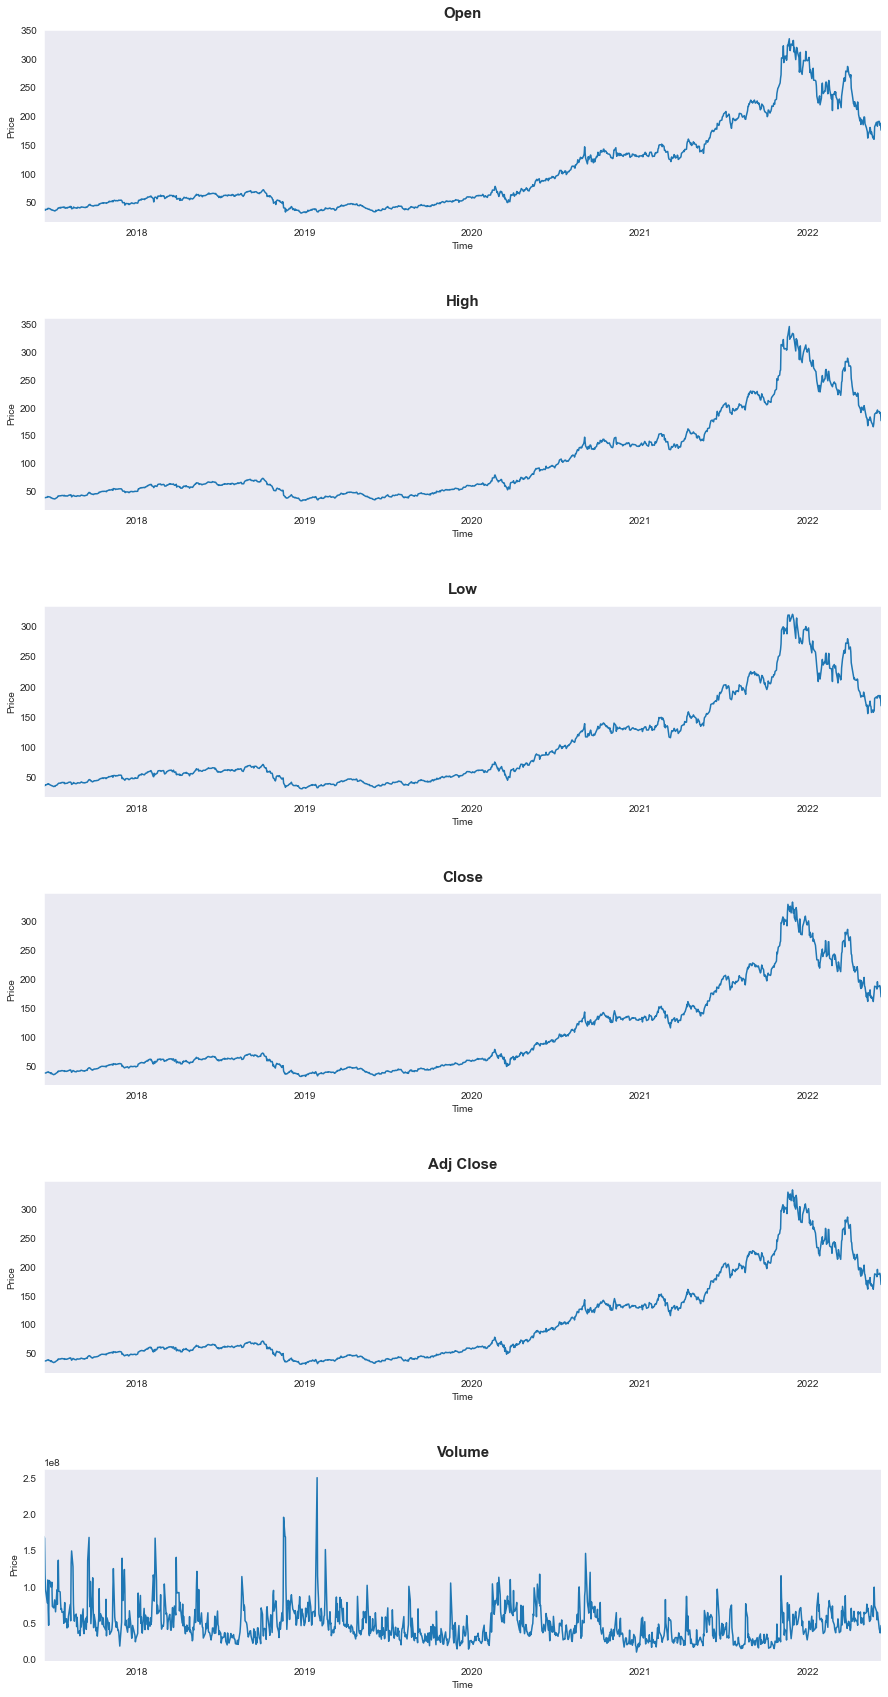

In [8]:
# Visualising the data
nvidia_forecast.visualise(data= "ts", 
                          ylabs= ["Price"] *len(nvidia_df.columns)
                         )

Now we need to determine the major trend for each column. First we
observe the moving average trends with the window of 6 months.
The graphs of the moving average trends are given as follows.

>>> Moving average trends are set


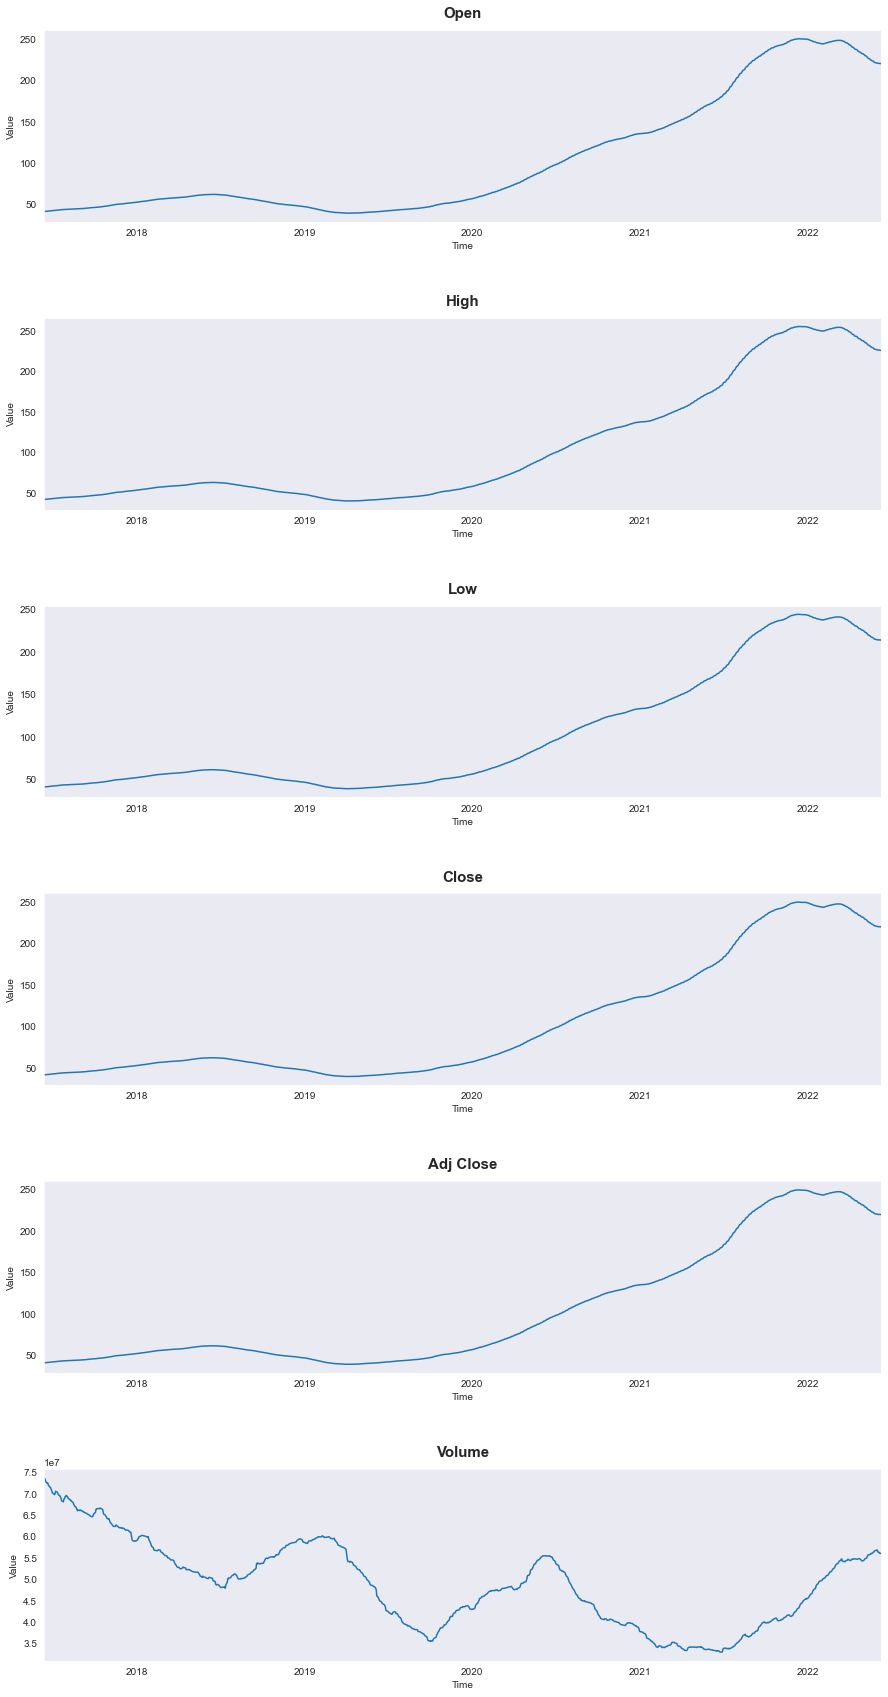

In [9]:
# Observing the major trends from moving average
# Let us set the window for 6 months:
nvidia_forecast.moving_avg_trends(window= 6 *30)
nvidia_forecast.visualise(data= "ma_trends")

From the moving average trends we can determine the major trends.
By making use of the method in the class that we have created earlier,
the approximated major trends are presented on the following graphs.

>>> Major trends are set


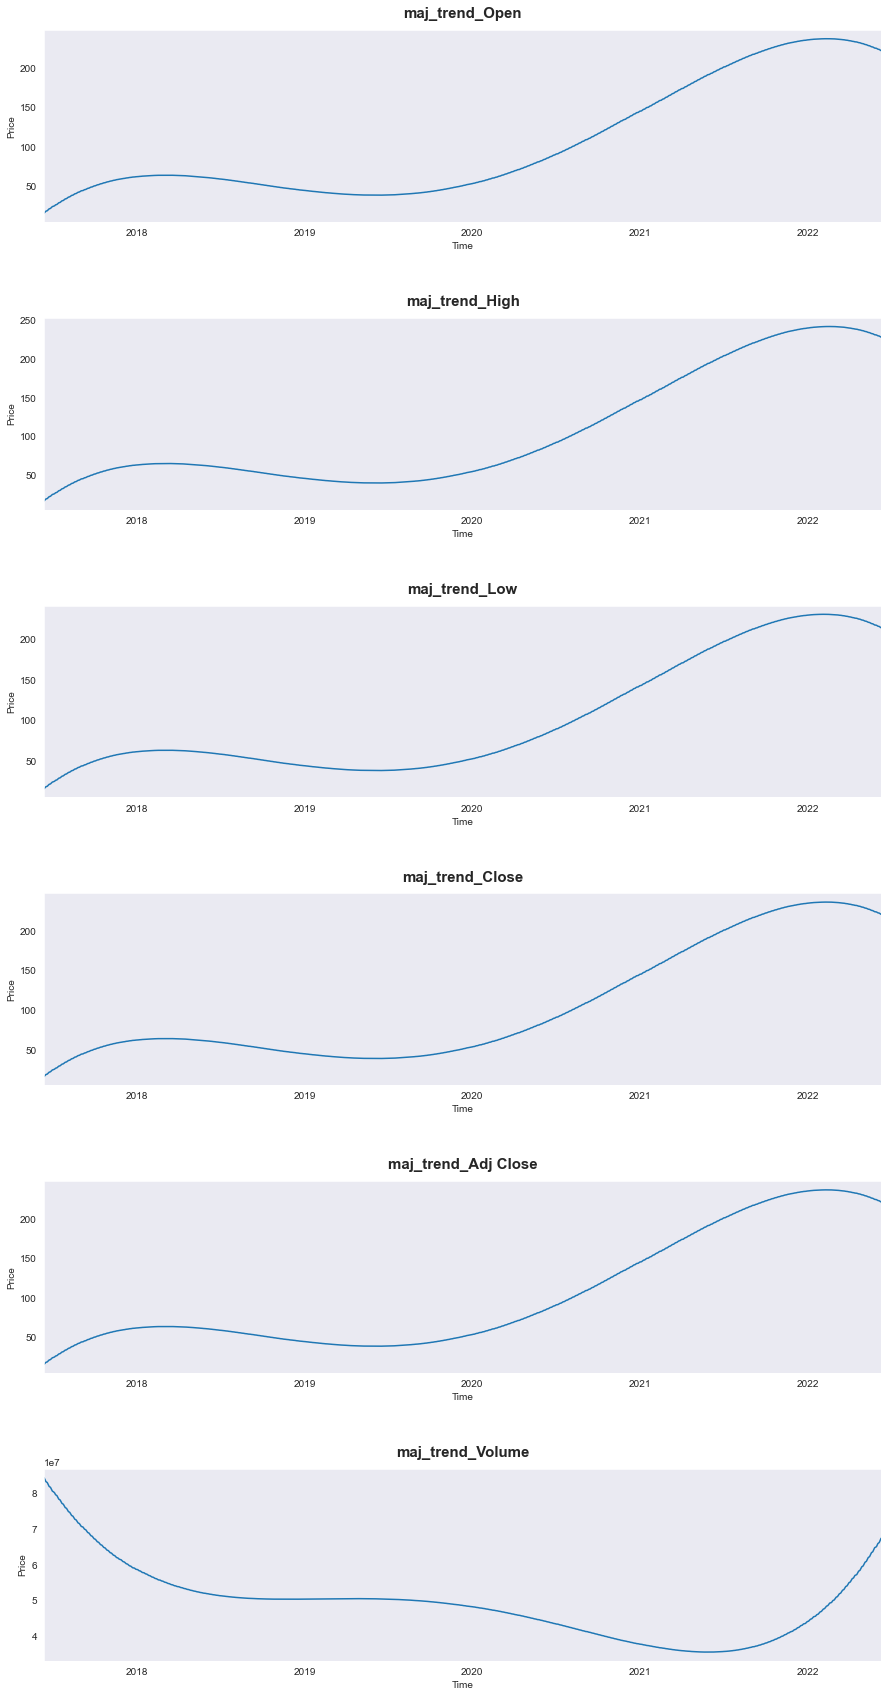

In [10]:
# Determining the major trends:
nvidia_forecast.set_major_trends()
nvidia_forecast.visualise(data= "maj_trends",
                          ylabs= ["Price"] *len(nvidia_df.columns))

Now we analyse the noises. The noises are determined by making use the
method avalaible in the class that we have created. The results are
presented on the following graphs.

>>> Noises are set


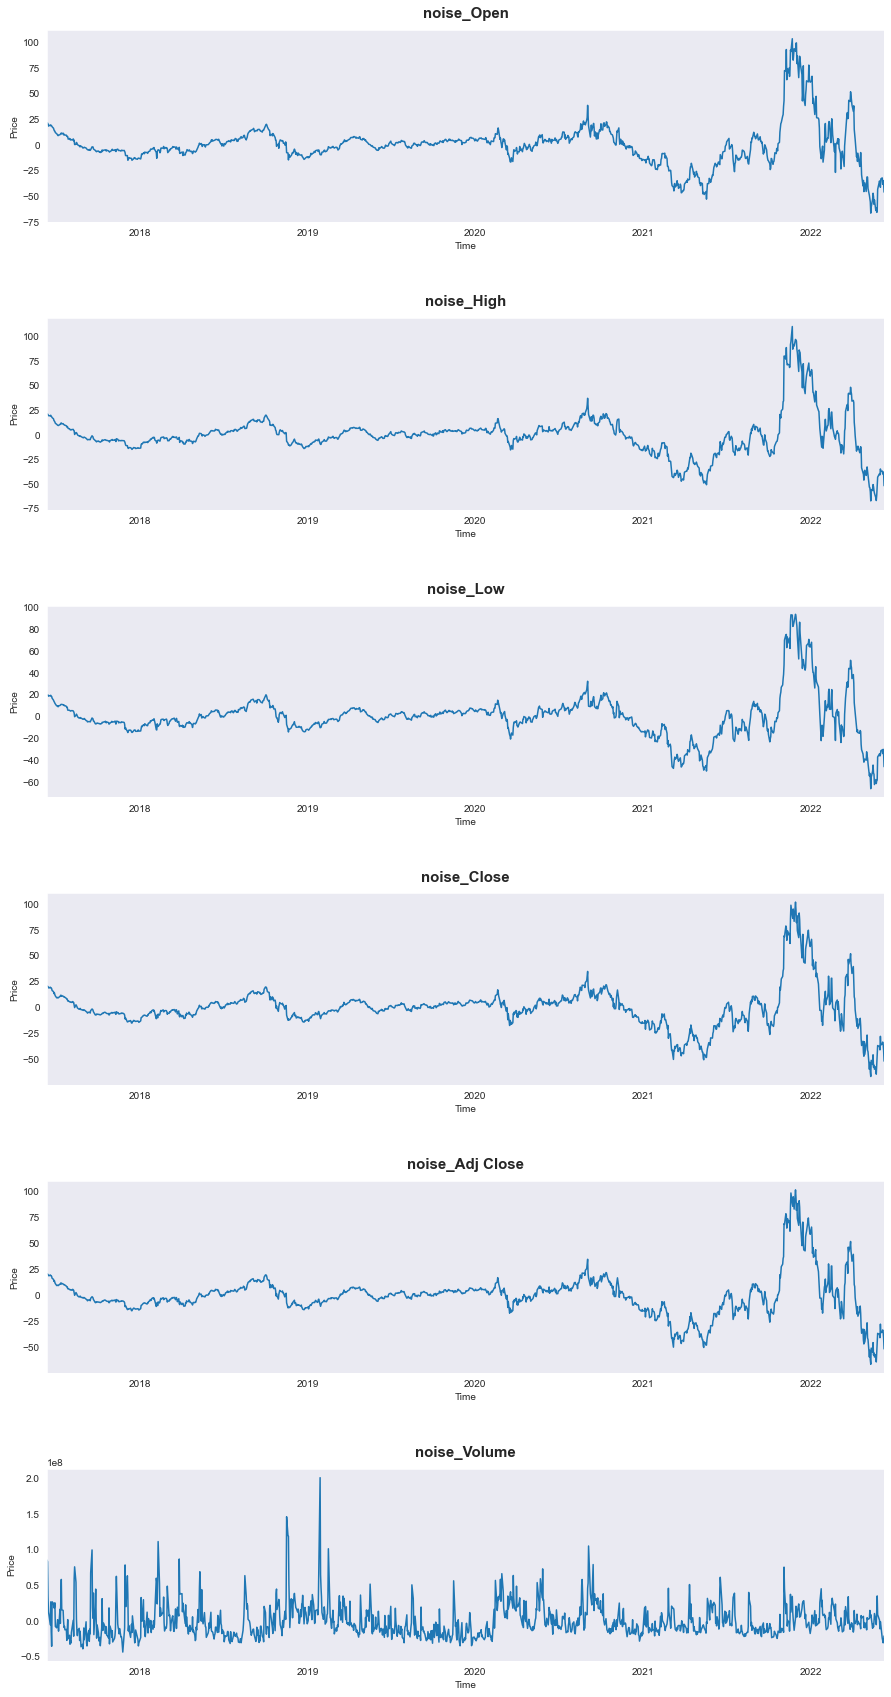

In [11]:
# Now we analyse the noise
nvidia_forecast.set_noises()
nvidia_forecast.visualise(data= "noises",
                          ylabs= ["Price"] *len(nvidia_df.columns))

Now we are to forecast the next 90 days prices of Nvidia stock.
Then let us observe the partial autocorrelation function (PACF) graph
of the possible lags for the noises' features. The PACFs are presented
as follows. The order of the graphs is the same as the order of the
columns in the timeseries data frame.

>>> Shifted noises are set


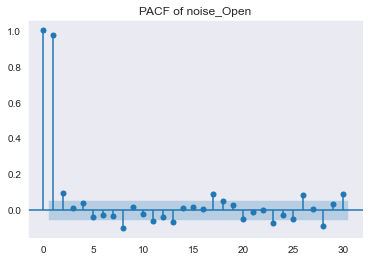

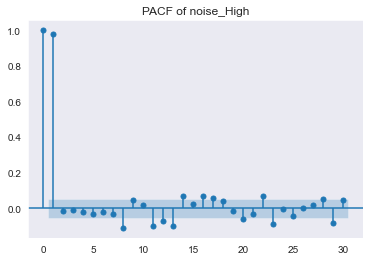

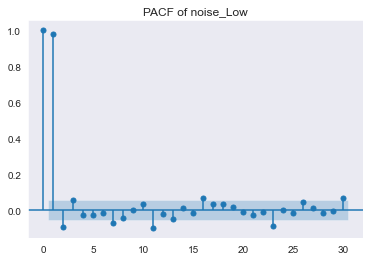

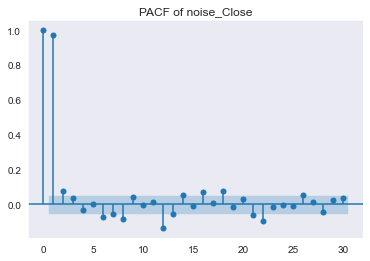

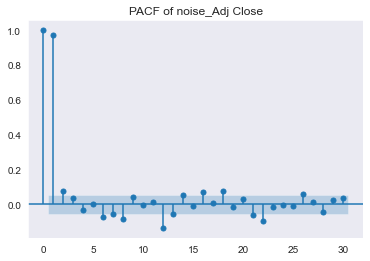

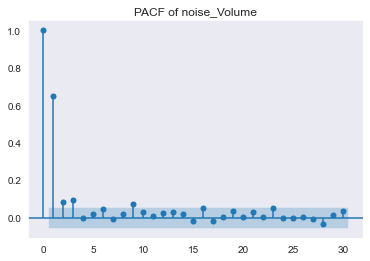

In [12]:
# Shifting the noises for 90 days forecast:
nvidia_forecast.set_noises_shift(90)

# PACF Shifted Noises:
nvidia_forecast.pacf_shifted_noises()

Based on the PACFs above, the numbers of lags are determined below.

In [13]:
chosen_lags = [
    [1, 2, 8, 11, 14, 17, 23, 26, 28, 30],
    [1, 8, 11, 12, 13, 14, 16, 22, 23, 29],
    [1, 2, 7, 11, 16, 23, 30],
    [1, 2, 6, 8, 12, 16, 18, 22],
    [1, 2, 6, 8, 121, 16, 17, 22],
    [1, 2, 3, 9]
]

Now we set the remaining forecasting tasks. The accuracy of the forecast
model is presented on the following table.

In [14]:
nvidia_forecast.set_shifted_noises_lags(chosen_lags)
print("Mean absolute error score of the model:")
nvidia_forecast.forecast(noise_mods= [LinearRegression,
                                      LinearRegression,
                                      LinearRegression,
                                      LinearRegression,
                                      LinearRegression,
                                      XGBRegressor],
                         show_validation= True)

>>> Lagged shifted noises are set
Mean absolute error score of the model:


Open       High        Low      Close  Adj Close  \
mean_abs_error  15.230953  15.391613  14.861554  14.407683  15.582108   

                      Volume  
mean_abs_error  2.388201e+07

>>> Forecasting has been done


And the forecasting results are presented on the following graphs.

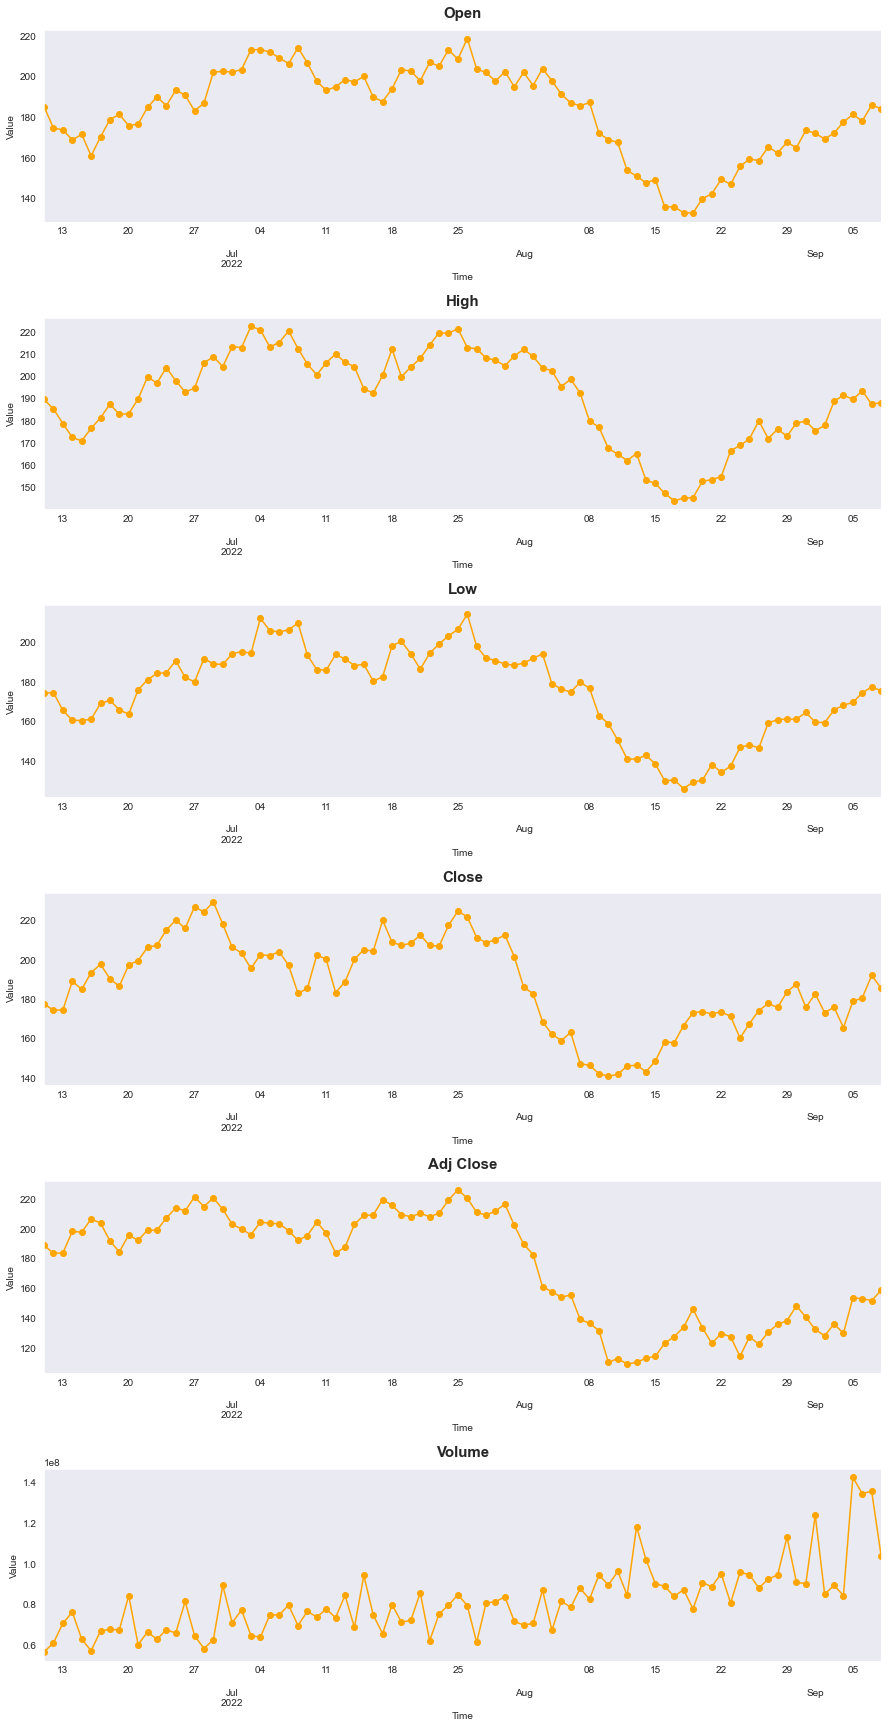

In [15]:
nvidia_forecast.visualise(data= "forecast")

The original time series combined with the next 90 days forecast
are presented on the following graphs.

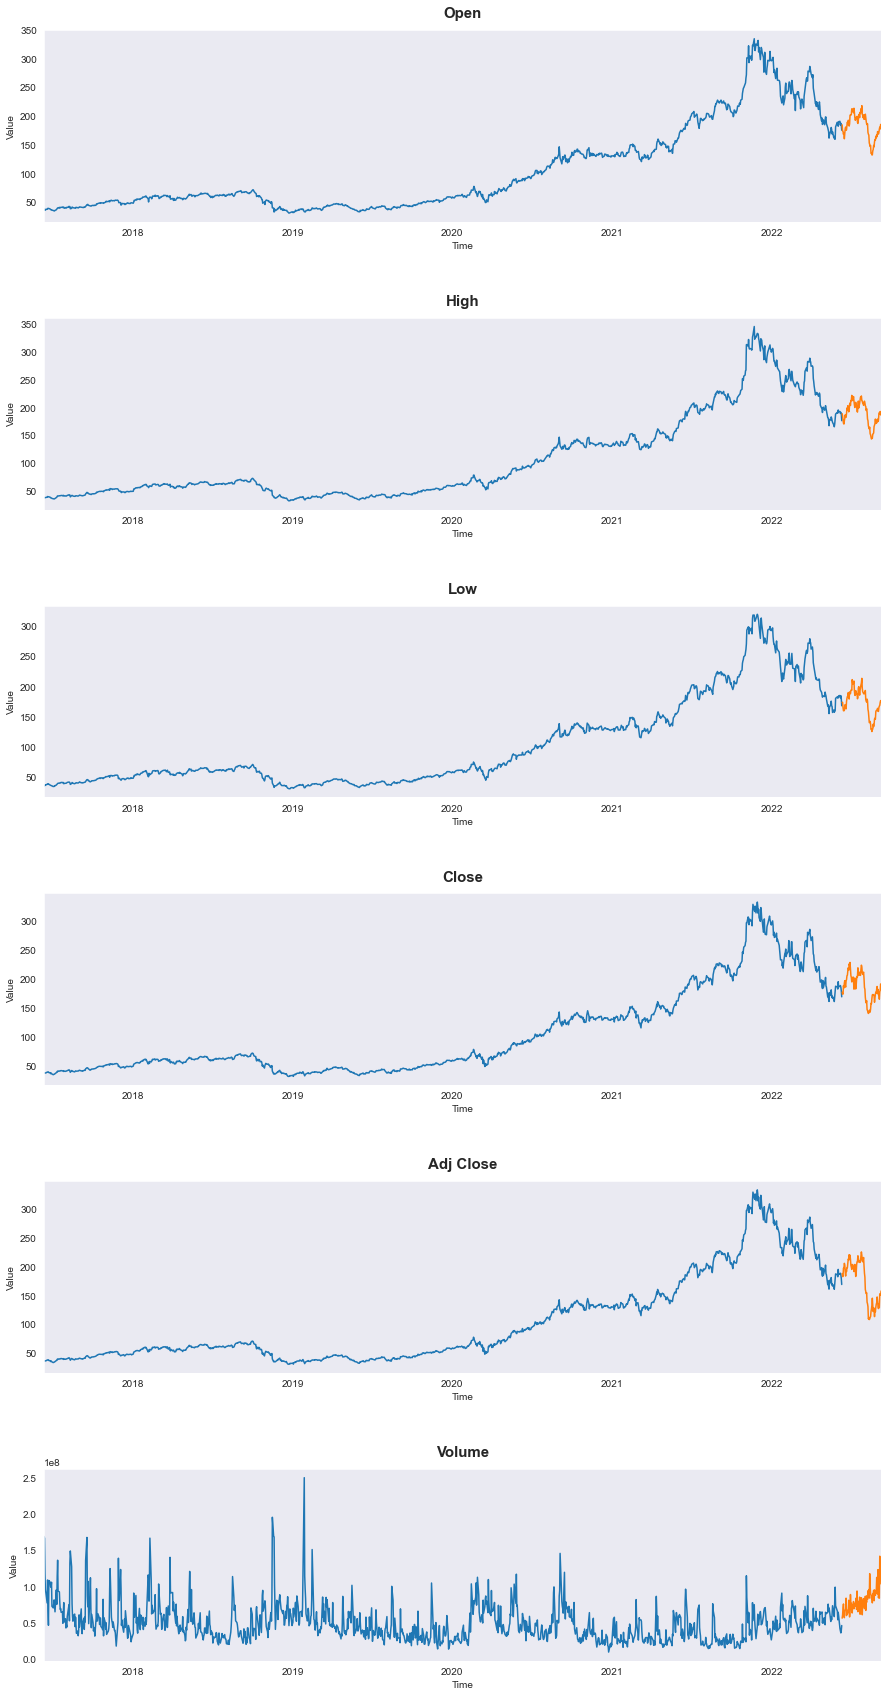

In [16]:
nvidia_forecast.visualise(data= "hist_fore")

On the graphs above, the blue curves represent the historical data
from the time seris, while the orange curves represent the forecasts
for the next 90 days.